# Rydberg Pair Potentials Near Surfaces

This tutorial is based on results that were published by J. Block and S. Scheel, "van der Waals interaction potential between Rydberg atoms near surfaces" [Physical Review A 96.6 (2017):062509](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.96.062509). We will reproduce the pair potentials shown in Figure 4. The final result is that for states around the $70p_{3/2}70p_{3/2}$-asymptote of Rubidium the strength of the pair interaction is reduced when placing the atoms in front of a perfect mirror (perfectly conducting plate) compared to the vacuum interaction.

As described in the [introduction](https://pairinteraction.github.io/pairinteraction/sphinx/html/introduction.html), we start our code with some preparations and load the necessary modules.

In case you encounter the error message 
"ModuleNotFoundError: No module named 'libpairinteraction'", add the following line right before "from libpairinteraction import pireal as pi":
`sys.path.append("/your/path/to/pairinteraction/build")`

In [1]:
%matplotlib inline

# Arrays
import numpy as np

# Plotting
import matplotlib.pyplot as plt
from itertools import product

# Operating system interfaces
import os, sys

# Parallel computing
from multiprocessing import Pool

# pairinteraction :-)
if sys.platform == "darwin": sys.path.append("/Applications/pairinteraction.app/Contents/Resources")
elif sys.platform == "win32": sys.path.append("C:\Program Files\pairinteraction")
#sys.path.append("/your/path/to/pairinteraction/build")
from libpairinteraction import pireal as pi

# Create cache for matrix elements
if not os.path.exists("./cache"):
    os.makedirs("./cache")
cache = pi.MatrixElementCache("./cache")

We can set the angle between the interatomic axis and the z-axis `theta` and the center of mass distance from the surface `distance_surface`. `distance_atom` defines the interatomic distances for which the pair potential is plotted. The units of the respective quantities are given as comments.

$\textit{Be}$ $\textit{careful}$: `theta = np.pi/2` corresponds to horizontal alignment of the two atoms with respect to the surface. For different angles, large interatomic distances `distance_atom` might lead to one of the atoms being placed inside the plate. Make sure that `distance_surface` > `distance_atom*np.cos(theta)/2`. 

In [2]:
theta = np.pi/2 # rad
distance_atom = np.linspace(6, 1.5, 50) # µm
distance_surface = 1 # µm

We provide a simple picture of the 2 atoms in front of the plate. Atomic radii are not to scale, `theta` is displayed.


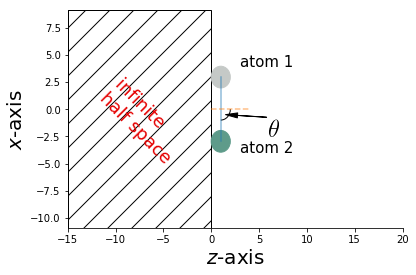

In [59]:
from matplotlib import pyplot
from matplotlib.patches import Circle
from matplotlib.patches import Rectangle
from matplotlib.patches import Arc

fig, ax = pyplot.subplots()

# Make the atoms; rotate so they are viewable with no z coordinates.
#setup atoms
atom_distance = distance_atom[1]
surface_distance = distance_surface

#setup half space
cornerleftx = -15
cornerlefty = min(-10,-atom_distance-5)
rectanglewidth = abs(cornerleftx)
rectangleheight = max(20,atom_distance+5)
halfspace = Rectangle((cornerleftx,cornerlefty),rectanglewidth,rectangleheight,angle=0.0,hatch='/ ',fill=False, alpha=1)
ax.add_patch(halfspace)
ax.annotate('infinite \nhalf space', xy=(0, 0), xytext=(-12,0),fontsize=18, color='xkcd:red', rotation=-45)

#atom coordinates
z1 = surface_distance - atom_distance*np.cos(theta)/2
x1 = atom_distance*np.sin(theta)/2
z2 = surface_distance + atom_distance*np.cos(theta)/2
x2 = -atom_distance*np.sin(theta)/2


#draw atom 1 as a circle
atom1 = Circle((z1,x1), 1 , color='xkcd:silver',edgecolor='k', linewidth=1,alpha=1, label='atom 1')
ax.add_patch(atom1)
ax.annotate('atom 1', xy=(0, 0), xytext=(z1+2,x1+1),fontsize=15)

#draw atom 2 as a circle
atom2 = Circle((z2,x2), 1 , color='xkcd:grey teal',edgecolor='k', linewidth=1,alpha=1, label='atom 2')
ax.add_patch(atom2)
ax.annotate('atom 2', xy=(0, 0), xytext=(z2+2,x2-1),fontsize=15)

#draw interatomic axis
line = ax.plot([z1,z2],[x1,x2], alpha=0.5, label='atomic distance')

#draw perpendicular line to surface through interatomic axis
ax.plot([max(0,surface_distance-3),max(4,surface_distance+3)],[0,0], alpha=0.5, linestyle='--')

#draw arc for theta
arc1 = Arc((surface_distance, 0),2,2,angle=0,theta1=-theta*180/np.pi,theta2=0,lw=1)
ax.add_patch(arc1)
ax.annotate('$\displaystyle\\theta$', xy=(surface_distance+0.5, -0.5), xytext=(surface_distance+5,-2.5),fontsize=25, usetex=True, arrowprops=dict(facecolor='black', shrink=50,width=0.1,headwidth=5))

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim((cornerleftx,max(20,z1+5,z2+5)))
ax.set_ylim((min(cornerlefty,x1-5,x2-5),max(cornerlefty+rectangleheight,x1+5,x2+5)))

# Enforce the circles are round (equal x and y scales) and turn off
# tickmarks.
#ax.axis('equal')

plt.xlabel("$z$-axis", fontsize=20)
#plt.set_xlim([-10,20])
plt.ylabel("$x$-axis", fontsize=20)
plt.show()

Next we define the state that we are interested in using pairinteraction's `StateOne` class . As shown in Figures 4 and 5 of [Physical Review A 96.6 (2017):062509](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.96.062509) we expect changes of about 50% for the $C_6$ coefficient of the $|69s_{1/2},m_j=1/2;72s_{1/2},m_j=1/2\rangle$ pair state, so this provides a good example. 

We set up the one-atom system using restrictions of energy, main quantum number n and angular momentum l. This is done by means of the `restrict...` functions in `SystemOne`.

In [52]:
state_one1 = pi.StateOne("Rb", 69, 0, 0.5, 0.5)
state_one2 = pi.StateOne("Rb", 72, 0, 0.5, 0.5)

# Set up one-atom system
system_one = pi.SystemOne(state_one1.getSpecies(), cache)
system_one.restrictEnergy(min(state_one1.getEnergy(),state_one2.getEnergy()) - 50, \
                          max(state_one1.getEnergy(),state_one2.getEnergy()) + 50)
system_one.restrictN(min(state_one1.getN(),state_one2.getN()) - 2, \
                     max(state_one1.getN(),state_one2.getN()) + 2)
system_one.restrictL(min(state_one1.getL(),state_one2.getL()) - 2, \
                     max(state_one1.getL(),state_one2.getL()) + 2)


The pair state `state_two` is created from the one atom states `state_one1` and `state_one2` using the `StateTwo` class.

From the previously set up system_one we define system_two using `SystemTwo` class. This class also contains methods `set..` to set angle, distance, surface distance and to `enableGreenTensor` in order implement a surface.

In [53]:
# Set up pair state
state_two = pi.StateTwo(state_one1, state_one2)


# Set up two-atom system
system_two = pi.SystemTwo(system_one, system_one, cache)
system_two.restrictEnergy(state_two.getEnergy() - 5, state_two.getEnergy() + 5)

system_two.setAngle(theta)
system_two.enableGreenTensor(True)
system_two.setDistance(distance_atom[0])
system_two.setSurfaceDistance(distance_surface)
system_two.buildInteraction()

Next, we diagonalize the system for the given interatomic distances in distance_atom and compare the free space system to a system at `distance_surface` away from the perfect mirror. The energy is calculated with respect to a Rubidium $|70p_{3/2},m_j=3/2;70p_{3/2},m_j=3/2\rangle$ two atom state, defined in `energyzero`.

In [54]:
# Diagonalize the two-atom system for different surface and interatomic distances
def getDiagonalizedSystems(distances):
    system_two.setSurfaceDistance(distances[0])
    system_two.setDistance(distances[1])
    system_two.diagonalize(1e-3)
    return system_two.getHamiltonian().diagonal()

if sys.platform != "win32":
    with Pool() as pool:
        energies = pool.map(getDiagonalizedSystems, product([1e12, distance_surface], distance_atom))
else:
    energies = list(map(getDiagonalizedSystems, product([1e12, distance_surface], distance_atom)))

energyzero = pi.StateTwo(["Rb", "Rb"], [70, 70], [1, 1], [1.5, 1.5], [1.5, 1.5]).getEnergy()
y = np.array(energies).reshape(2, -1)-energyzero
x = np.repeat(distance_atom, system_two.getNumBasisvectors())


Finally, we plot the result. Save the figure by adding 
`fig.savefig("/path/to/your/plots/plot.pdf")`
at the bottom.

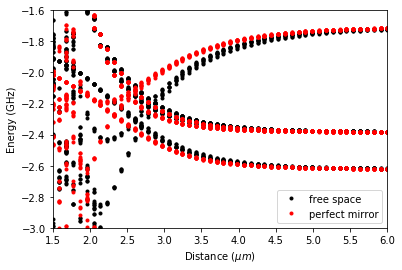

In [55]:
# Plot pair potentials
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel(r"Distance ($\mu m$)")
ax.set_ylabel(r"Energy (GHz)")
ax.set_xlim(np.min(distance_atom),np.max(distance_atom))
ax.set_ylim(-3, -1.6)
ax.plot(x, y[0], 'ko', ms=3, label = 'free space')
ax.plot(x, y[1], 'ro', ms=3, label = 'perfect mirror')
ax.legend();
#fig.savefig("/path/to/your/plots/plot.pdf")